In [1]:
%reload_ext autoreload
%autoreload 2

# Transport

## Waveform generation

In [4]:

import numpy as np
from pytrans import objectives as obj
from pytrans.conversion import freq_to_curv
from pytrans.ions import Ca40
from pytrans.functions import zpspace
from pytrans.solver import solver, init_waveform

from models.surface_trap import SurfaceTrap
from pathlib import Path

data_dir = Path('.') / 'data'


In [ ]:




trap = SurfaceTrap()

axial = freq_to_curv(1e6, ion=Ca40)
rtilt = 8e7

n_samples = 50
x = zpspace(trap.x_ele(2), trap.x_ele(4), n_samples, k=5, gap=1.75)
y0 = 0
z0 = trap.z0

waveform = init_waveform(n_samples, trap.n_electrodes)

objectives = []

# fill objectives per-step
def step_objective(voltages, x):
    return [
        obj.GradientObjective(voltages, trap, x, y0, z0, value=0, ion=Ca40),
        obj.HessianObjective(voltages, trap, x, y0, z0, entries='xx', value=axial, ion=Ca40, pseudo=False),
        obj.HessianObjective(voltages, trap, x, y0, z0, entries='yz', value=rtilt, ion=Ca40, pseudo=False),
    ]

for j, x0 in enumerate(x):
    objectives += step_objective(waveform[j], x0)

objectives += [
    obj.VoltageObjective(waveform, 0),
    obj.VoltageObjective(waveform, 10, constraint_type='<='),
    obj.VoltageObjective(waveform, -10, constraint_type='>='),
    obj.SlewRateObjective(waveform, dt=trap.dt, weight=1e4)
    # obj.SlewRateObjective(waveform, value=4e6, dt=trap.dt, constraint_type='<=')  # V/s
]

_ = solver(objectives, verbose=True)
waveform = waveform.value  # get array from cvxpy variable

savename = data_dir / 'waveform_transport.npy'
print(f"Saving waveform as ndarray to {savename}")
np.save(savename, waveform)


## Analysis

In [5]:
import numpy as np
import matplotlib.pyplot as plt

from models.surface_trap import SurfaceTrap
from models.surface_trap.plot import plot_voltages_on_trap
from pytrans.analysis import analyse_potential
from pytrans.plotting.plotting import plot_potential_make_layout

from pytrans.ions import Ca40, Be9

In [6]:
trap = SurfaceTrap()
waveform = np.load(data_dir / 'waveform_transport.npy')

Analyse first / middle / last sample

--------------
Trap potential analysis for ion Ca40: 
Equilibrium position [um]
[100.0008  -0.0004  67.083 ]
Gradient [V/m]
[ 0.0016 -0.2042  0.503 ]
Displacement at 1 MHz [um]
[ 0.0001 -0.0125  0.0308]
Hessian [V/m2]
[[ 1.6351e+07 -7.2772e+05 -5.5904e+05]
 [-7.2772e+05  6.2875e+08  8.0010e+07]
 [-5.5904e+05  8.0010e+07  5.6369e+08]]
Normal mode frequencies [MHz]
[0.999965 5.58399 6.46107]
Eigenvectors
[[1 0.00108 0.000864]
 [0.000117 0.558 -0.83]
 [-0.00137 0.83 0.558]]
Tilt angle of mode 2 (6.46): 33.94°

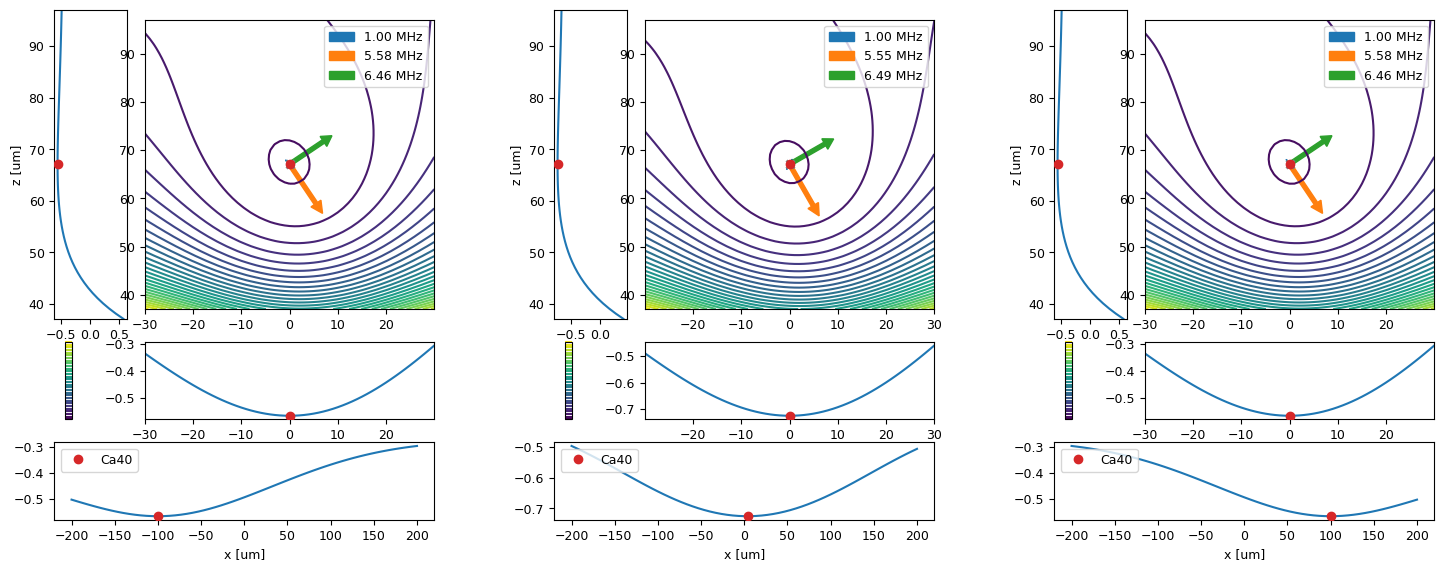

In [7]:
r0 = (0, 0, trap.z0)
roi = ((-200e-6, 200e-6), 30e-6, 30e-6)

fig, axes = plot_potential_make_layout(3)
res1 = analyse_potential(trap, voltages=waveform[0], ions=Ca40, r0=r0, roi=roi, verbose=False, axes=axes[0])
res1 = analyse_potential(trap, voltages=waveform[len(waveform) // 2], ions=Ca40, r0=r0, roi=roi, verbose=False, axes=axes[1])
res2 = analyse_potential(trap, voltages=waveform[-1], ions=Ca40, r0=r0, roi=roi, verbose=False, axes=axes[2])

res2

In [11]:
from pytrans.analysis import analyse_waveform
results = analyse_waveform(trap, waveform, ions=[Ca40, Ca40], ion1=Ca40, r0=r0, roi=roi)


Waveform analysis: 100%|██████████| 50/50 [00:07<00:00,  7.07it/s]


In [12]:

import json

rj = [r.to_json() for r in results]
with open(data_dir / 'analysis_transport.json', 'w') as fp:
    json.dump(rj, fp, indent=2)


In [13]:
x_eq = np.stack([r.x_eq * 1e6 for r in results], axis=0)
freqs = np.stack([r.mode_freqs * 1e-6 for r in results], axis=0)


In [14]:
x_eq2 = np.stack([r.mode_solver_results.x_eq * 1e6 for r in results], axis=0)


In [15]:
x_eq2.shape

(50, 2, 3)

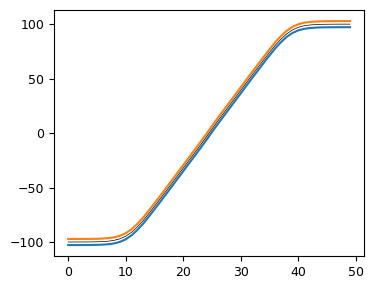

In [34]:
plt.figure(figsize=(4, 3.2))
plt.plot(x_eq2[:, :, 0], '-', ms=1)
plt.plot(x_eq[:, 0], 'k', lw=0.5)


In [18]:
xx = x_eq[:, 0]
freqs.shape

(50, 3)

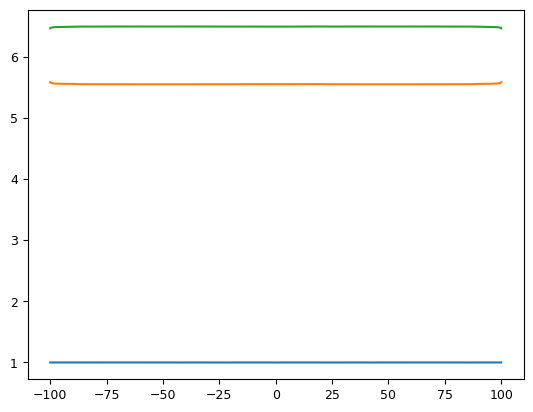

In [19]:

plt.plot(xx, freqs);

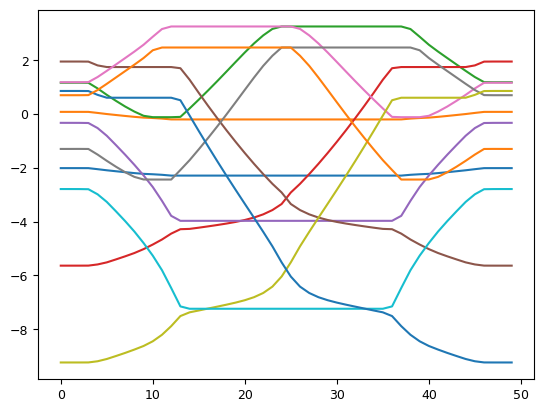

In [20]:
plt.plot(waveform); 

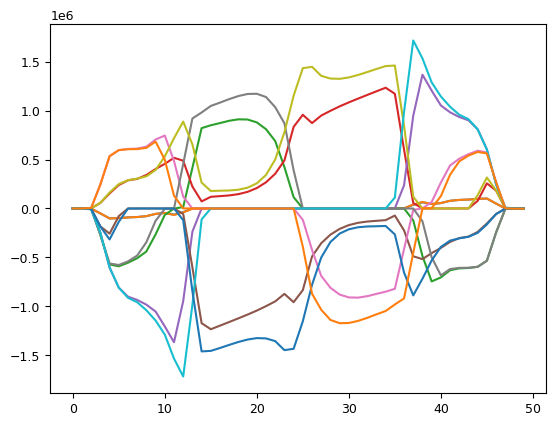

In [21]:
v_diff = np.gradient(waveform, axis=0) / trap.dt
plt.plot(v_diff);

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.PillowWriter'>


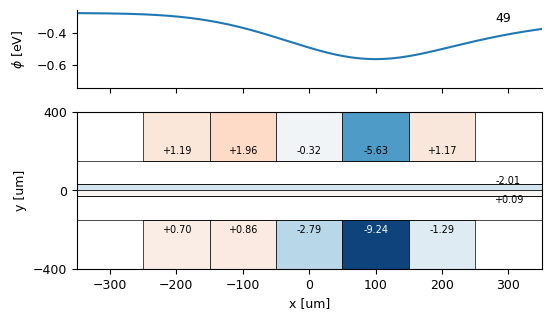

In [28]:
from models.surface_trap.plot import animate_waveform_on_trap

ani = animate_waveform_on_trap(trap, waveform)
ani.save(data_dir / 'waveform_transport.gif', fps=20)


[]

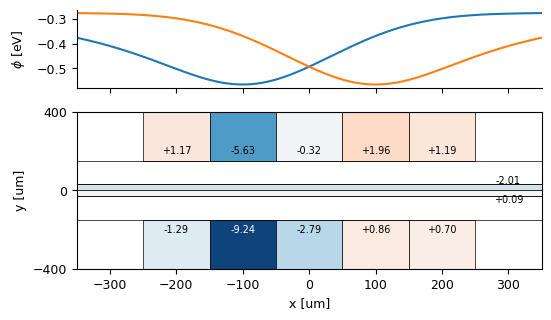

In [33]:
fig, (ax, ax0) = plot_voltages_on_trap(trap, waveform[0])
# _ = plot_voltages_on_trap(trap, waveform[-1])
x = trap.x
p = trap.potential(waveform[-1], x, 0, trap.z0, Ca40.mass_amu)
ax.plot(x*1e6, p)
ax.set(
    # xlim=(-450, 450)
)
